# Setting

In [1]:
from pf_utils import PortfolioManager as PM 
from pf_utils import BayesianEstimator, performance_stats, get_date_range, METRICS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

In [3]:
file_cost='transaction_cost'

# Data

In [4]:
universe = 'UV_FUND'
fund = PM.create_universe(universe)
cost = PM.get_cost(universe, file=file_cost, path=path_tran)
fee = cost['fee']

64 securities from 2008-11-28 to 2024-12-31 uploaded.
REMINDER: 64 equities converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless
Price data loaded
Cost data transaction_cost_241217.csv loaded


In [5]:
df_prices = fund.df_prices
df_prices_fees = fund._get_prices_after_fee(df_prices, fee)

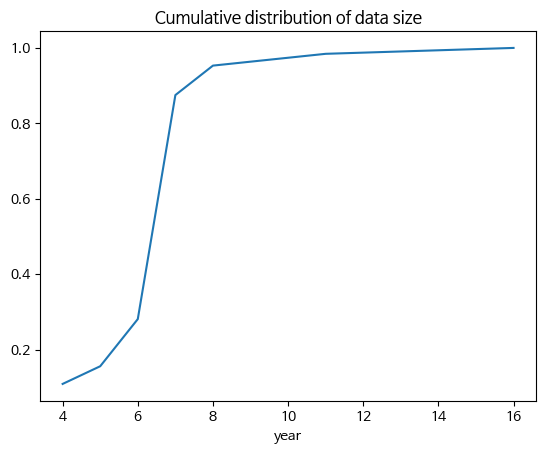

In [6]:
days_in_year = fund.days_in_year
df_year = get_date_range(df_prices).loc[:, 'n'].div(days_in_year).rename('year')
_ = df_year.groupby(df_year.round()).count().cumsum().div(df_year.count()).plot(title='Cumulative distribution of data size')

# Bayesian

*revert data to original montly for estimation*

In [7]:
days_in_year = 12
df_prc = df_prices_fees.resample('M').last()

## 1 Year Rate of Return

In [8]:
freq = 12
file_est = f'fund_ror_{round(freq/12)}y_250107'
file_est

'fund_ror_1y_250107'

### Split

In [9]:
y = 4 # mean data size
tickers = df_year.loc[df_year >= y].index.to_list()
len(tickers)

58

In [10]:
n = days_in_year
df_p = df_prc[tickers]
df_train = df_p.iloc[:-n]
df_val = df_p.iloc[-n:]

In [11]:
len(df_p), len(df_train), len(df_val)

(194, 182, 12)

### Estimate

In [12]:
kw = dict(
    days_in_year = days_in_year,
    security_names = fund.security_names
)

*Sample*

In [25]:
be = BayesianEstimator(df_train, **kw)
be.bayesian_sample(freq=freq, file=file_est, path=path_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 170 seconds.


data/fund_ror_1y_250107.pkl saved


*Load*

In [13]:
be = BayesianEstimator.create(file_est, path_data, **kw)

data/fund_ror_1y_250107.pkl loaded


#### Visualize

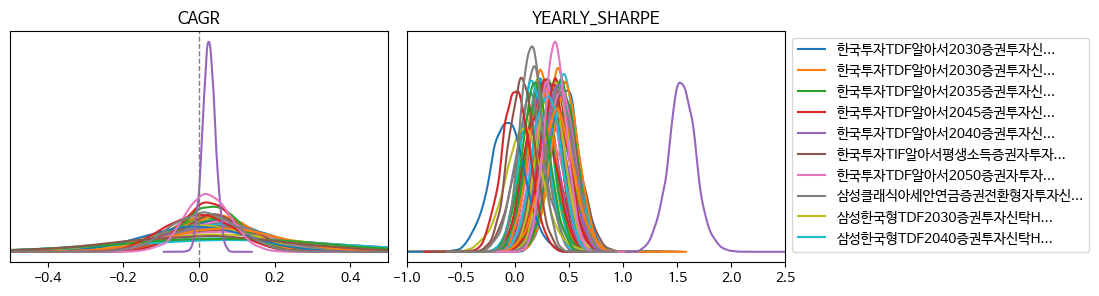

In [14]:
#xlims = None
xlims = [(-0.5, 0.5), (-1, 2.5)]
_ = be.plot_returns(max_legend=10, xlims=xlims)

### Compare

In [27]:
var_name = 'cagr'
df_s = be.bayesian_summary(var_name).droplevel(0)
ms = ['mean','sd','hdi_3%','hdi_97%']
ascending = [False, True, False, False]
pick = lambda i, n=5: df_s.sort_values(ms[i], ascending=ascending[i]).iloc[:n].index.to_list()

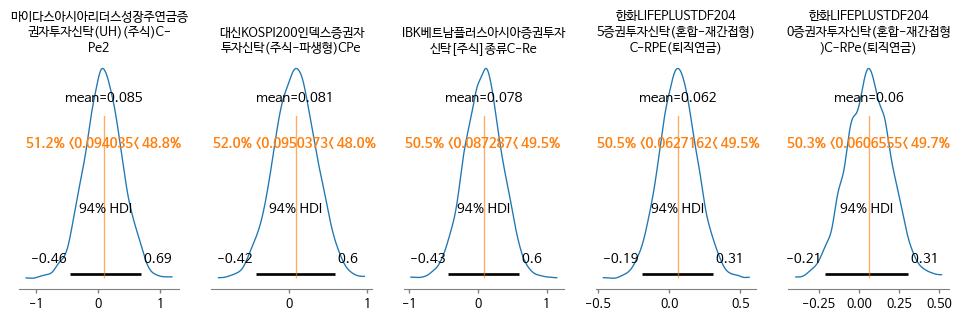

In [34]:
t0 = pick(0)
kw = dict(ref_val='default', figsize=(12,3), textsize=9, grid=(1,5), length=16)
be.plot_posterior(var_name, t0, **kw)

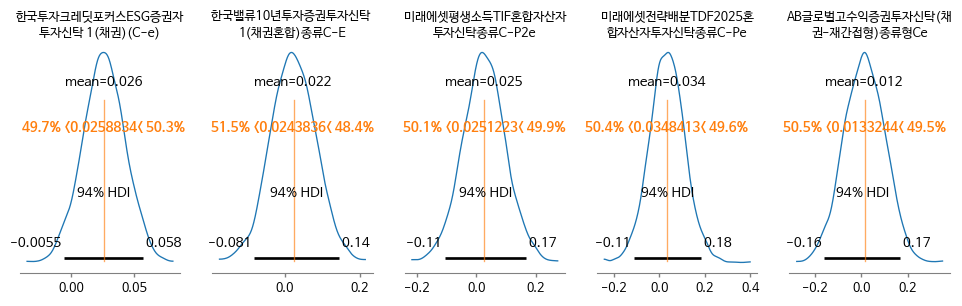

In [35]:
t1 = pick(1)
be.plot_posterior(var_name, t1, **kw)

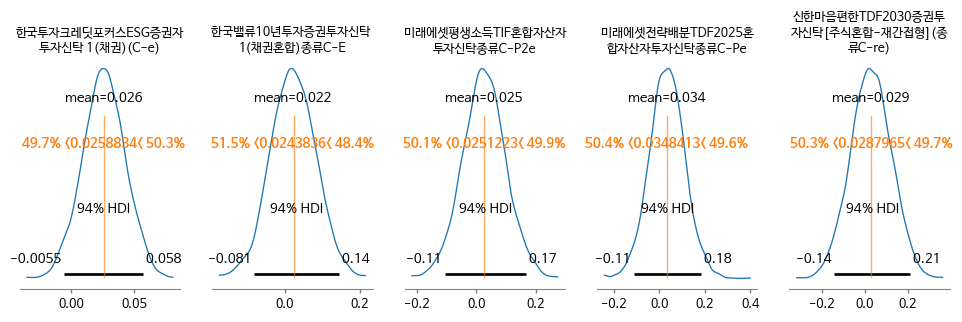

In [36]:
t2 = pick(2)
be.plot_posterior(var_name, t2, **kw)

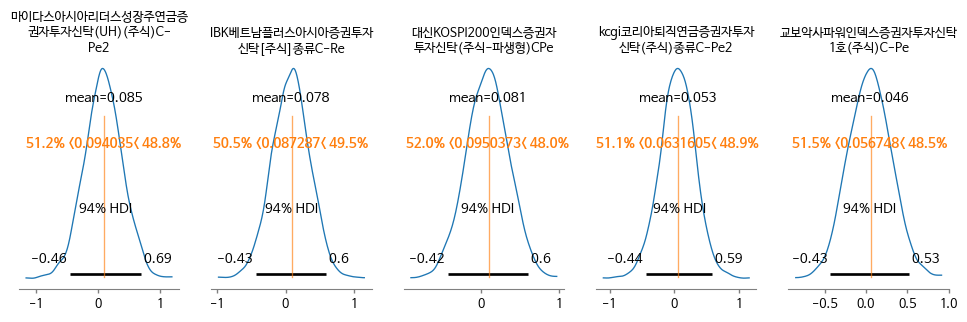

In [37]:
t3 = pick(3)
be.plot_posterior(var_name, t3, **kw)

#### Validate

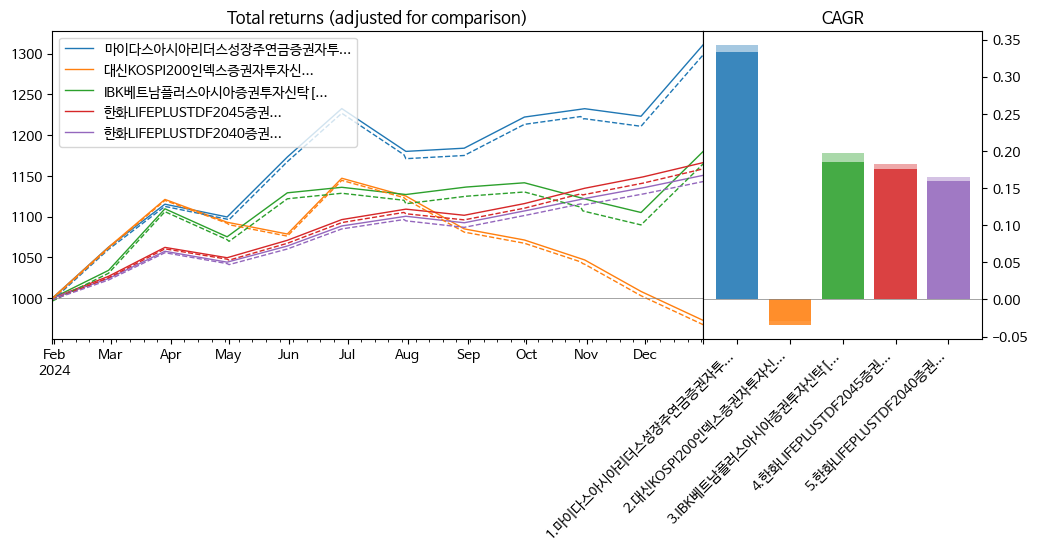

In [40]:
#m = 'total_return'
m = 'cagr'
start = df_val.index.min()
fund.plot(t0, fee=fee, base=1000, metric=m, start_date=start)

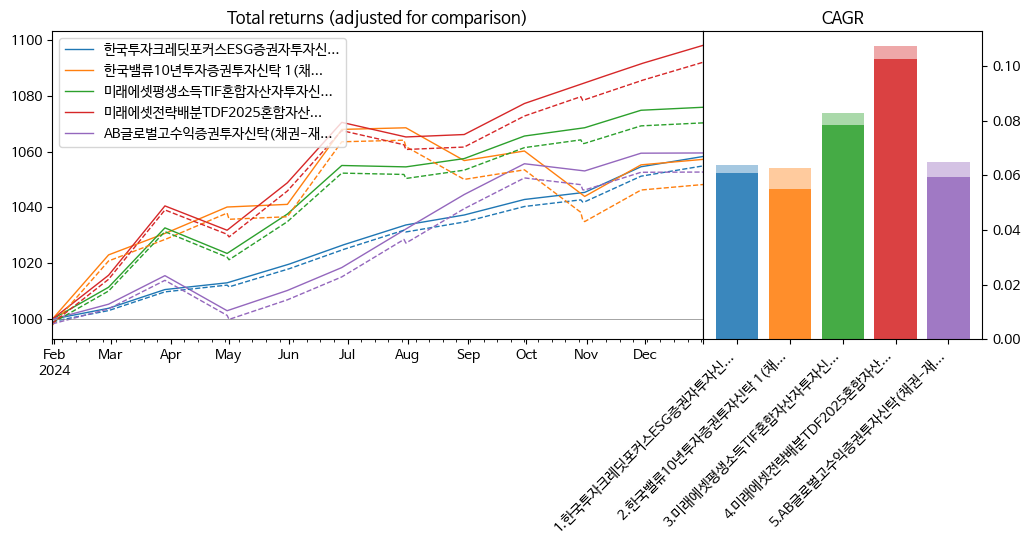

In [41]:
fund.plot(t1, fee=fee, base=1000, metric=m, start_date=start)

## 3 Year Rate of Return

In [42]:
freq = 12*3
file_est = f'fund_ror_{round(freq/12)}y_250107'
file_est

'fund_ror_3y_250107'

### Split

In [43]:
y = 7 # mean data size
tickers = df_year.loc[df_year >= y].index.to_list()
len(tickers)

39

In [44]:
n = days_in_year * 3
df_p = df_prc[tickers]
df_train = df_p.iloc[:-n]
df_val = df_p.iloc[-n:]

In [45]:
len(df_p), len(df_train), len(df_val)

(194, 158, 36)

### Estimate

In [46]:
kw = dict(
    days_in_year = days_in_year,
    security_names = fund.security_names
)

*Sample*

In [47]:
be = BayesianEstimator(df_train, **kw)
be.bayesian_sample(freq=freq, file=file_est, path=path_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.


data/fund_ror_3y_250107.pkl saved


*Load*

In [49]:
be = BayesianEstimator.create(file_est, path_data, **kw)

data/fund_ror_3y_250107.pkl loaded


#### Visualize

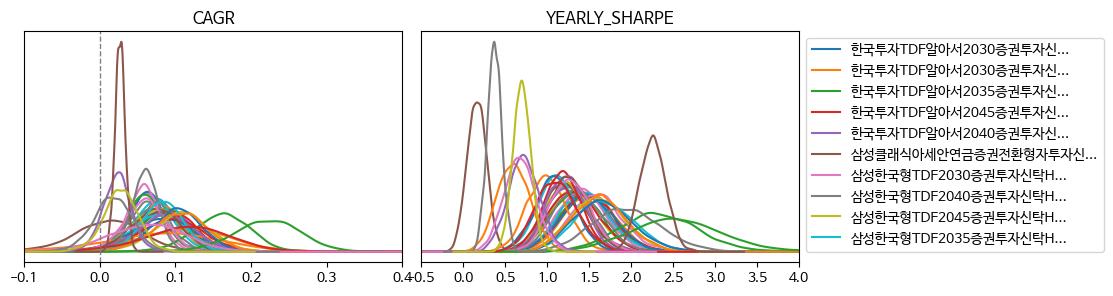

In [52]:
xlims = None
xlims = [(-0.1, 0.4), (-0.5, 4)]
_ = be.plot_returns(max_legend=10, xlims=xlims)

### Compare

In [53]:
var_name = 'cagr'
ms = ['mean','sd','hdi_3%','hdi_97%']
ascending = [False, True, False, False]

df_s = be.bayesian_summary(var_name).droplevel(0)
pick = lambda i, n=5: df_s.sort_values(ms[i], ascending=ascending[i]).iloc[:n].index.to_list()

arviz - WARNING - Array contains NaN-value.


In [60]:
#df_s.isna().any(axis=1).sum()
df_s = df_s.dropna()

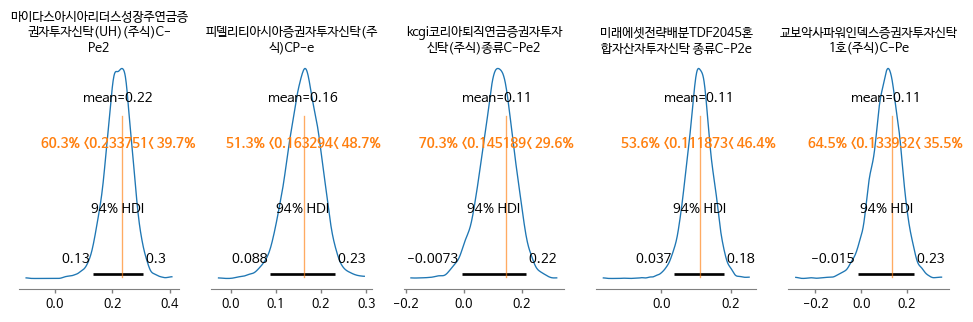

In [61]:
t0 = pick(0)
kw = dict(ref_val='default', figsize=(12,3), textsize=9, grid=(1,5), length=16)
be.plot_posterior(var_name, t0, **kw)

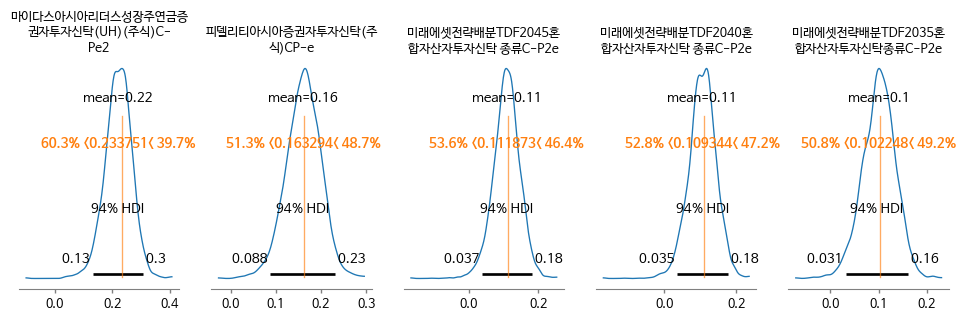

In [63]:
t2 = pick(2)
be.plot_posterior(var_name, t2, **kw)

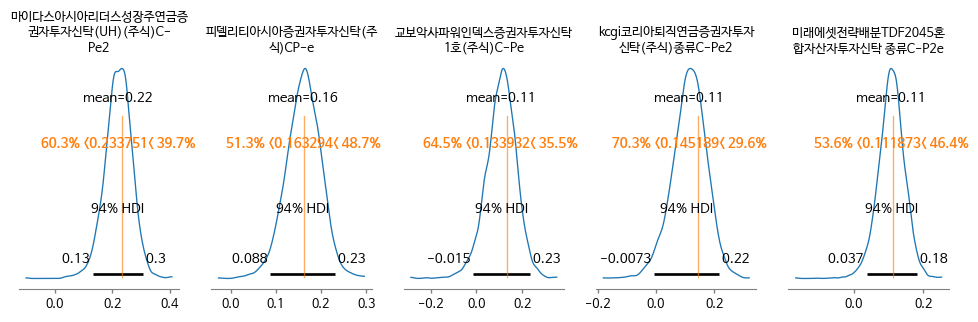

In [64]:
t3 = pick(3)
be.plot_posterior(var_name, t3, **kw)

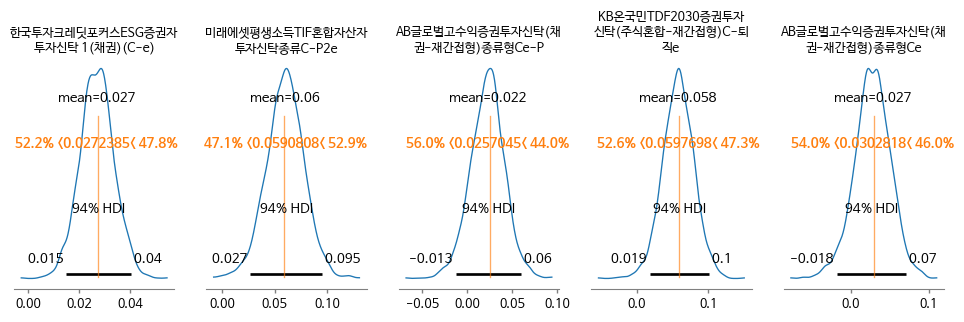

In [65]:
t1 = pick(1)
be.plot_posterior(var_name, t1, **kw)

#### Validate

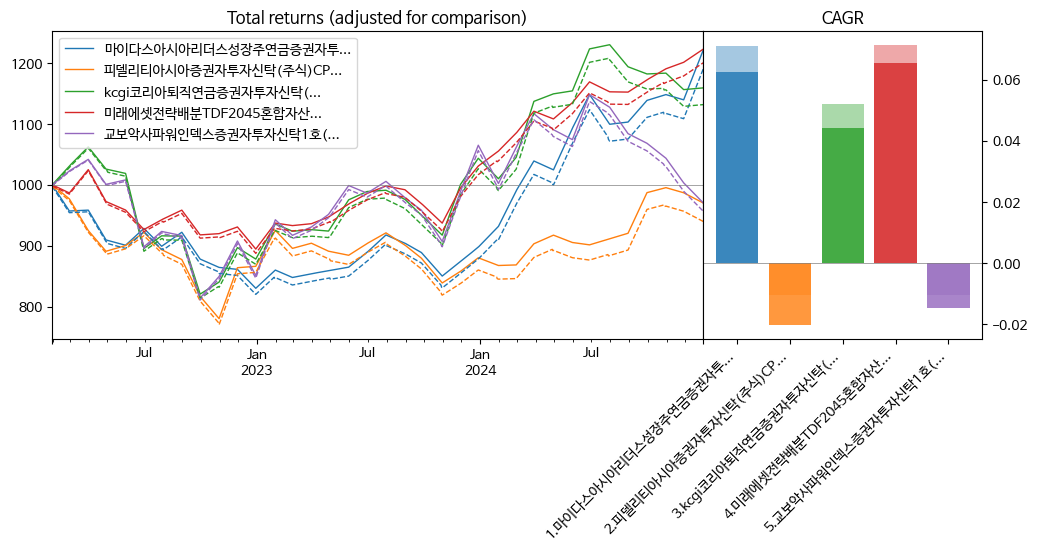

In [66]:
#m = 'total_return'
m = 'cagr'
start = df_val.index.min()
fund.plot(t0, fee=fee, base=1000, metric=m, start_date=start)

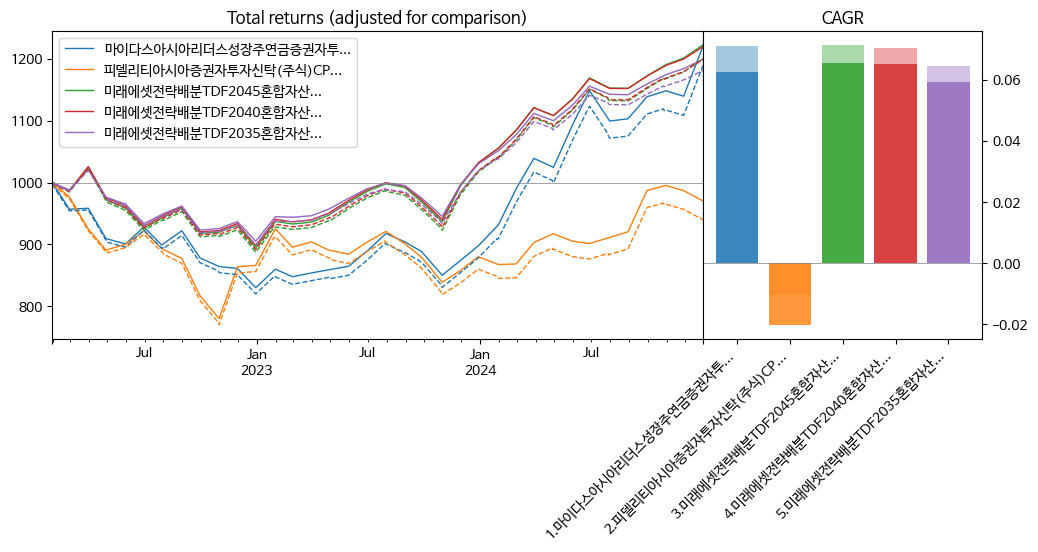

In [67]:
fund.plot(t2, fee=fee, base=1000, metric=m, start_date=start)

## All

In [8]:
freq = 12*3
file_est = f'fund_ror_all_{round(freq/12)}y_250107'
file_est

'fund_ror_all_3y_250107'

### Split

In [9]:
n = days_in_year
df = df_prc.apply(lambda x: x.dropna().count()) >= freq + n
tickers = df.loc[df].index

df_p = df_prc[tickers]
df_train = df_p.iloc[:-n]
df_val = df_p.iloc[-n:]

In [10]:
len(df_p), len(df_train), len(df_val)

(194, 182, 12)

In [11]:
df_p.columns.size

58

### Estimate

In [12]:
kw = dict(
    days_in_year = days_in_year,
    security_names = fund.security_names
)

*Sample*

In [94]:
be = BayesianEstimator(df_train, **kw)
be.bayesian_sample(freq=freq, file=file_est, path=path_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 199 seconds.


data/fund_ror_all_3y_250107.pkl saved


*Load*

In [13]:
be = BayesianEstimator.create(file_est, path_data, **kw)

data/fund_ror_all_3y_250107.pkl loaded


#### Visualize

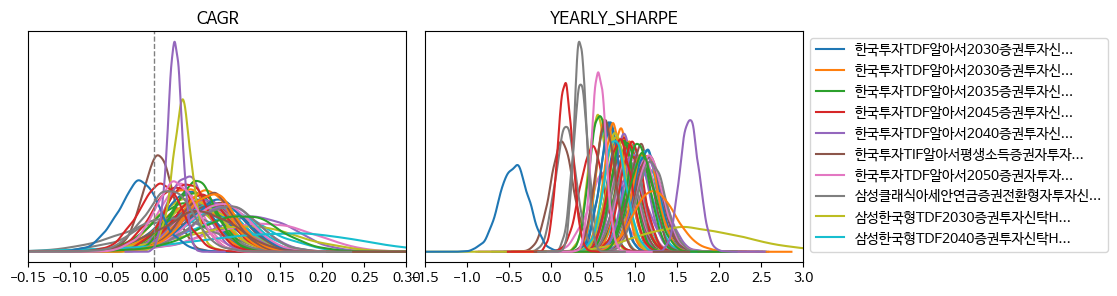

In [99]:
#xlims = None
xlims = [(-0.15, 0.3), (-1.5, 3)]
_ = be.plot_returns(max_legend=10, xlims=xlims)

### Compare

In [14]:
var_name = 'cagr'
ms = ['mean','sd','hdi_3%','hdi_97%']
ascending = [False, True, False, False]

df_s = be.bayesian_summary(var_name).droplevel(0)
pick = lambda i, n=5: df_s.sort_values(ms[i], ascending=ascending[i]).iloc[:n].index.to_list()

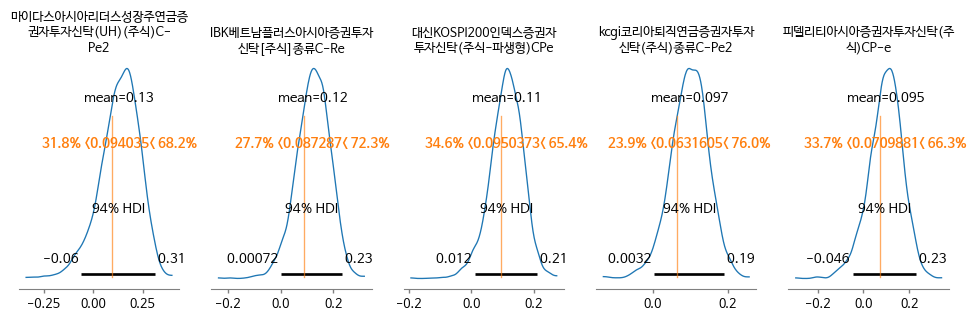

In [15]:
t0 = pick(0)
kw = dict(ref_val='default', figsize=(12,3), textsize=9, grid=(1,5), length=16)
be.plot_posterior(var_name, t0, **kw)

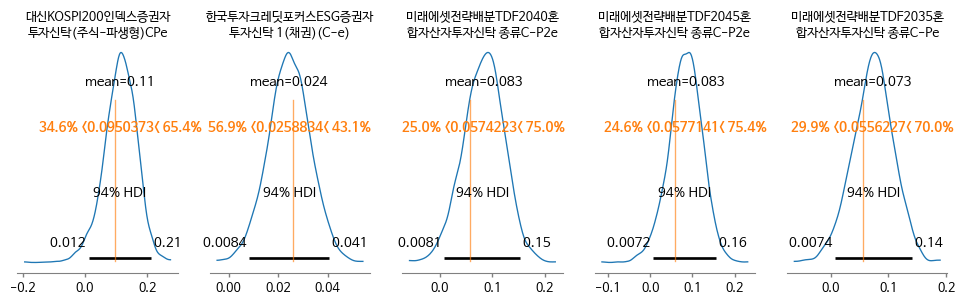

In [16]:
t2 = pick(2)
be.plot_posterior(var_name, t2, **kw)

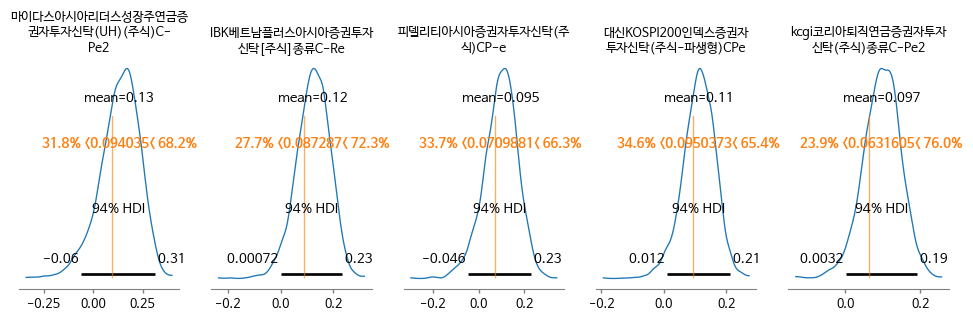

In [17]:
t3 = pick(3)
be.plot_posterior(var_name, t3, **kw)

#### Validate

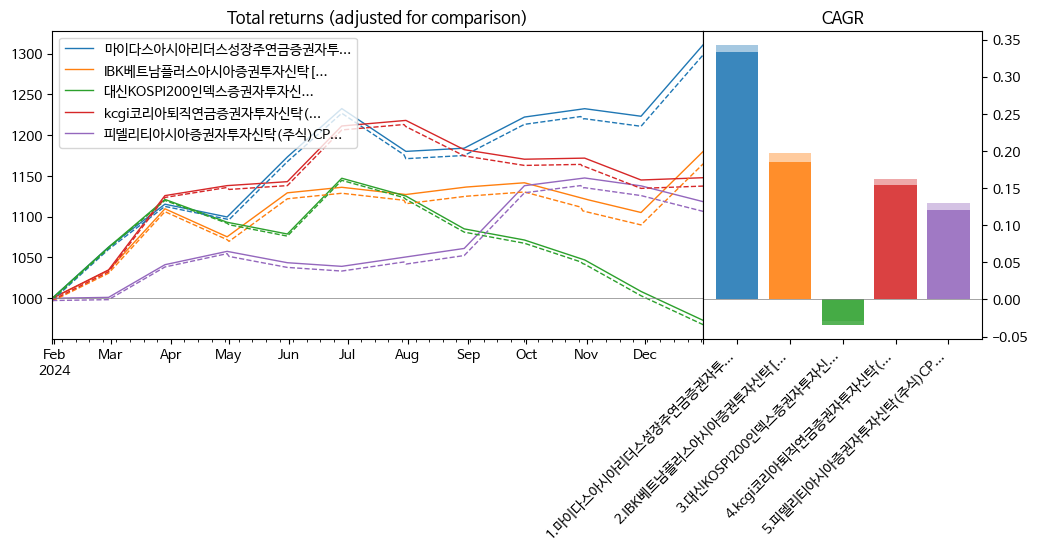

In [105]:
#m = 'total_return'
m = 'cagr'
start = df_val.index.min()
fund.plot(t0, fee=fee, base=1000, metric=m, start_date=start)

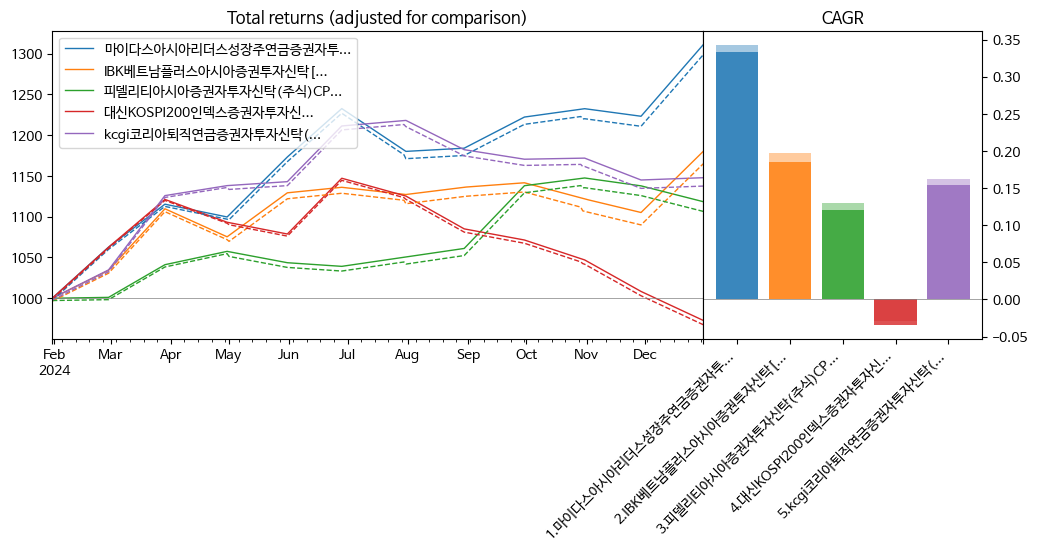

In [106]:
fund.plot(t3, fee=fee, base=1000, metric=m, start_date=start)

## All train

In [8]:
freq = 12*3
file_est = f'fund_ror_all2_{round(freq/12)}y_250107'
file_est

'fund_ror_all2_3y_250107'

In [9]:
df = df_prc.apply(lambda x: x.dropna().count()) > freq
tickers = df.loc[df].index

df_p = df_prc[tickers]
df_train = df_p

In [10]:
df_p.columns.size

64

### Estimate

In [11]:
kw = dict(
    days_in_year = days_in_year,
    security_names = fund.security_names
)

*Sample*

In [137]:
be = BayesianEstimator(df_train, **kw)
be.bayesian_sample(freq=freq, file=file_est, path=path_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 193 seconds.


data/fund_ror_all2_3y_250107.pkl saved


*Load*

In [12]:
be = BayesianEstimator.create(file_est, path_data, **kw)

data/fund_ror_all2_3y_250107.pkl loaded


#### Visualize

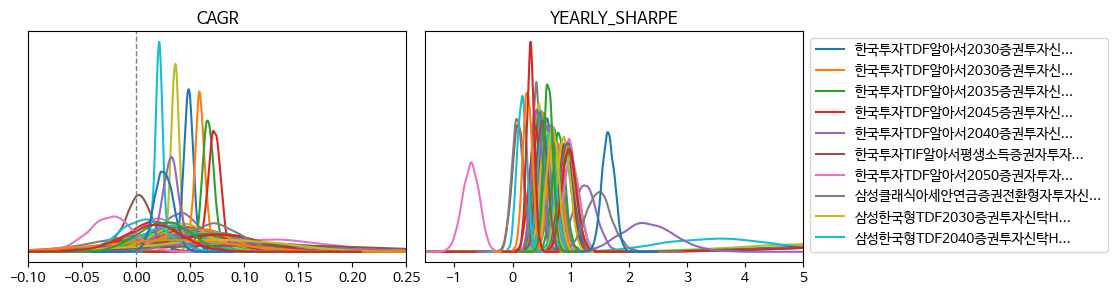

In [14]:
#xlims = None
xlims = [(-0.1, 0.25), (-1.5, 5)]
_ = be.plot_returns(max_legend=10, xlims=xlims)

### Compare

In [13]:
var_name = 'cagr'
ms = ['mean','sd','hdi_3%','hdi_97%']
ascending = [False, True, False, False]

df_s = be.bayesian_summary(var_name).droplevel(0)
pick = lambda i, n=5, df=df_s: df.sort_values(ms[i], ascending=ascending[i]).iloc[:n].index.to_list()

arviz - WARNING - Array contains NaN-value.


In [14]:
#df_s.isna().any(axis=1).sum()
df_s = df_s.dropna()

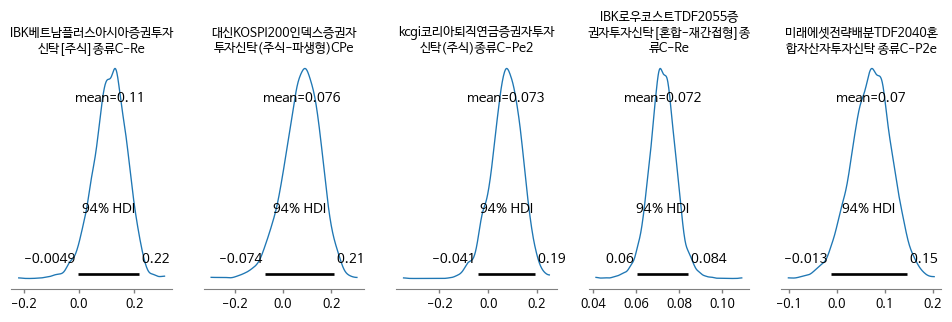

In [15]:
t0 = pick(0)
kw = dict(
    #ref_val='default', 
    figsize=(12,3), textsize=9, grid=(1,5), length=16)
be.plot_posterior(var_name, t0, **kw)

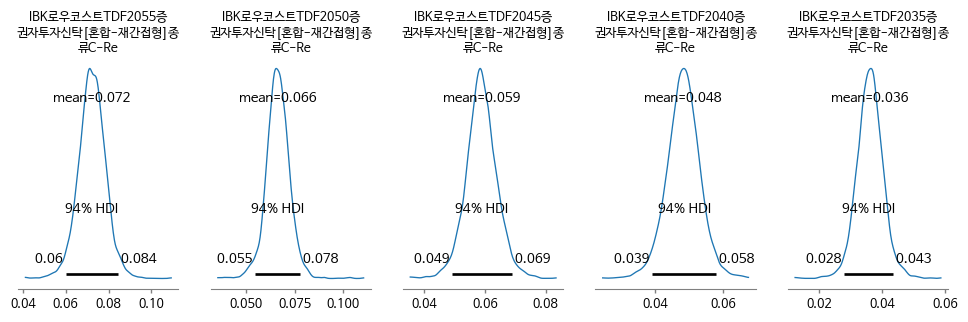

In [16]:
t2 = pick(2)
be.plot_posterior(var_name, t2, **kw)

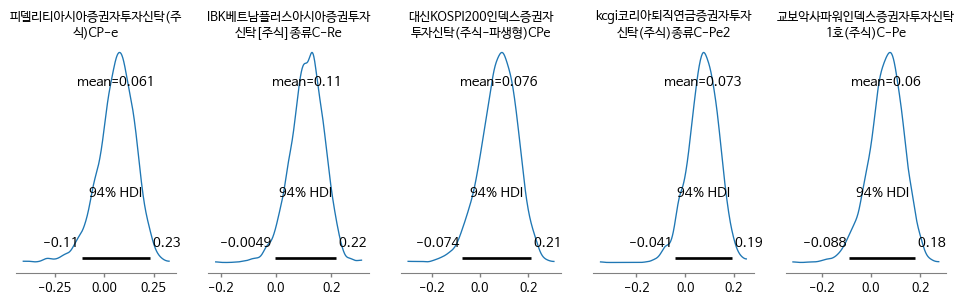

In [17]:
t3 = pick(3)
be.plot_posterior(var_name, t3, **kw)

# Visualize

In [18]:
from pf_dash import create_app

In [19]:
df_prc = df_prices.resample('M').last()
df_prc_f = df_prices_fees[tickers].resample('M').last()
fund_name = fund.security_names

In [20]:
#tickers = fund_name.keys()

In [21]:
tickers = list(set(t0 + t2 + t3))
#tickers = t0

In [22]:
ticker_dropdown = [{'label':v, 'value':v, 'title':fund_name[v], 'search':fund_name[v]} for v in tickers]
data_prc = {'before fees':df_prc[tickers], 'after fees':df_prc_f[tickers]}

In [23]:
create_app(data_prc, ticker_dropdown, fund_name=fund_name)